In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hungle3401/faceforensics")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/faceforensics


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Should show 1+

Num GPUs Available:  0


# Cell 1: Setup and Install Tools 

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor  # Updated to avoid deprecation
import cv2
from mtcnn import MTCNN
import os
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm  

# Set device (GPU in Kaggle)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cpu


# Cell 2: Data Preparation (With Progress and Visuals)

In [ ]:

# Define your OWN directories for real and fake videos
# Make sure these paths are correct based on your Kaggle environment

real_dir = r'archive\FF++\real'  # Folder with real videos    
fake_dir = r'archive\FF++\fake'  # Folder with fake videos

# Extracting faces 
def extract_faces_from_video(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    detector = MTCNN()
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)

    for i in range(0, frame_count, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        faces = detector.detect_faces(frame_rgb)
        if faces:
            x, y, w, h = faces[0]['box']
            face = frame_rgb[y:y+h, x:x+w]
            face = cv2.resize(face, (224, 224))
            frames.append(Image.fromarray(face))
    cap.release()
    return frames

# Imports for progress and visualization
from tqdm import tqdm
import matplotlib.pyplot as plt

# Updated Dataset class with progress and limit ( 50 videos per folder for speed) - now single-threaded
# Multithredding needs to be avoided in Kaggle due to resource limits

class DeepfakeDataset(Dataset):
    def __init__(self, image_processor, max_videos_per_class=100):   # Currently set to 100 for accuracy
        self.images = []
        self.labels = []
        self.image_processor = image_processor

        # Process real videos (single-threaded with progress)
        real_files = [f for f in os.listdir(real_dir) if f.endswith('.mp4')][:max_videos_per_class]
        print("Processing real videos (single-threaded)...")
        for file in tqdm(real_files):
            frames = extract_faces_from_video(os.path.join(real_dir, file))
            self.images.extend(frames)
            self.labels.extend([0] * len(frames))  # 0 = real

        # Process fake videos (single-threaded with progress)
        fake_files = [f for f in os.listdir(fake_dir) if f.endswith('.mp4')][:max_videos_per_class]
        print("Processing fake videos (single-threaded)...")
        for file in tqdm(fake_files):
            frames = extract_faces_from_video(os.path.join(fake_dir, file))
            self.images.extend(frames)
            self.labels.extend([1] * len(frames))  # 1 = fake

        print(f"Extracted {len(self.images)} face images from videos.")

        # Showing num of fake and real images 
        num_real = sum(1 for label in self.labels if label == 0)
        num_fake = sum(1 for label in self.labels if label == 1)
        print(f"Class Balance: Real images: {num_real}, Fake images: {num_fake}")

        # Visualize a sample
        if self.images:
            sample_img = self.images[0]
            plt.imshow(sample_img)
            plt.title("Sample Face (Real)" if self.labels[0] == 0 else "Sample Face (Fake)")
            plt.show()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        inputs = self.image_processor(img, return_tensors='pt').pixel_values.squeeze(0)  # Updated
        return {'pixel_values': inputs, 'labels': self.labels[idx]}

# Load image processor 
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Create dataset (limit to 50 videos each for speed)
# Currently set to 100 for accuracy
dataset = DeepfakeDataset(image_processor, max_videos_per_class=100)

# Split 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Total images: {len(dataset)} (Train: {train_size}, Test: {test_size})")

# Cell 3: Model Setup

In [ ]:

class ConViTInspired(nn.Module):
    def __init__(self, num_classes=2):
        super(ConViTInspired, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=num_classes, ignore_mismatched_sizes=True)

        # Convolutional layer to extract features (expands to 16 channels, inspired by paper)
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)

        # New: Projection layer to reduce back to 3 channels (fixes the error!)
        self.proj = nn.Conv2d(16, 3, kernel_size=1)  # 1x1 conv to match ViT input

        self.relu = nn.ReLU()

    def forward(self, pixel_values, labels=None):
        x = self.conv(pixel_values)  # Apply conv (now 16 channels)
        x = self.relu(x)
        x = self.proj(x)  # Project back to 3 channels
        outputs = self.vit(pixel_values=x, labels=labels)  # Now it matches ViT's expectation
        return outputs

# Create model and move to device
model = ConViTInspired(num_classes=2).to(device)

# layers for fine-tuning 
for param in model.vit.parameters():
    param.requires_grad = True  # UnFreeze ViT base
for param in model.vit.classifier.parameters():
    param.requires_grad = True  # Unfreeze classifier
for param in model.conv.parameters():
    param.requires_grad = True  # Train the conv layer
for param in model.proj.parameters():  # New: Train the projection layer too
    param.requires_grad = True

print("Model loaded with pretrained weights and channel fix!")
print("Model ready!")

# Cell 4: Fine-Tuning with Progress

Recalculated Class Balance for Weights: Real: 1052, Fake: 1083


Epoch 1: 100%|██████████| 214/214 [15:05<00:00,  4.23s/it, loss=0.355]


Epoch 1 Avg Loss: 0.6021


Epoch 2: 100%|██████████| 214/214 [16:18<00:00,  4.57s/it, loss=0.866] 


Epoch 2 Avg Loss: 0.3747


Epoch 3: 100%|██████████| 214/214 [16:07<00:00,  4.52s/it, loss=0.0816] 


Epoch 3 Avg Loss: 0.2084


Epoch 4: 100%|██████████| 214/214 [16:24<00:00,  4.60s/it, loss=0.0677] 


Epoch 4 Avg Loss: 0.1540


Epoch 5: 100%|██████████| 214/214 [16:22<00:00,  4.59s/it, loss=0.126]   


Epoch 5 Avg Loss: 0.0876


Epoch 6: 100%|██████████| 214/214 [16:16<00:00,  4.56s/it, loss=0.0554]  


Epoch 6 Avg Loss: 0.0691


Epoch 7: 100%|██████████| 214/214 [16:08<00:00,  4.52s/it, loss=0.0003]  


Epoch 7 Avg Loss: 0.0785


Epoch 8: 100%|██████████| 214/214 [16:21<00:00,  4.59s/it, loss=0.00715] 


Epoch 8 Avg Loss: 0.0666


Epoch 9: 100%|██████████| 214/214 [16:25<00:00,  4.61s/it, loss=2.5e-5]  


Epoch 9 Avg Loss: 0.0220


Epoch 10: 100%|██████████| 214/214 [16:22<00:00,  4.59s/it, loss=0.00217] 

Epoch 10 Avg Loss: 0.0477


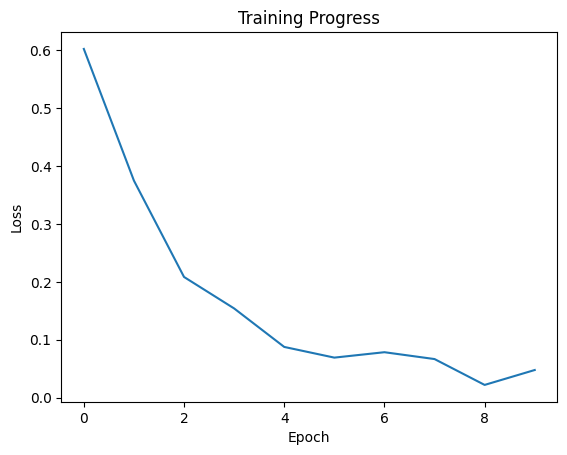

In [ ]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=5e-5)  # Lower LR for stability

# New: Recalculate class counts from the dataset (fixes NameError)
num_real = sum(1 for label in dataset.labels if label == 0)
num_fake = sum(1 for label in dataset.labels if label == 1)
print(f"Recalculated Class Balance for Weights: Real: {num_real}, Fake: {num_fake}")

# New: Add class weights to handle imbalance (weight fakes higher if fewer)
if num_real == 0 or num_fake == 0:
    class_weights = torch.tensor([1.0, 1.0]).to(device)  # Fallback if one class is empty
else:
    class_weights = torch.tensor([1.0, num_fake / num_real] if num_real > num_fake else [num_real / num_fake, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted loss

losses = []
num_epochs = 10  # Increase for better training
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values, labels=labels)
        loss = criterion(outputs.logits, labels)  # Use weighted criterion
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

# Plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

# Cell 5: Testing

In [ ]:

test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot()
plt.show()


accuracy = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Cell 6: Predict on a Single Video (Upload your own via /kaggle/input or add a path)

In [ ]:

def predict_video(video_path):
    frames = extract_faces_from_video(video_path, num_frames=5)
    if not frames:
        return "No faces"
    preds = []
    with torch.no_grad():
        for frame in frames:
            inputs = image_processor(frame, return_tensors='pt').pixel_values.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
            preds.append(pred)
    avg_pred = np.mean(preds) > 0.5
    return "Fake" if avg_pred else "Real"

# Example: Test on a video from dataset (change path)
test_video ="archive/FF++/fake/01_11__talking_against_wall__9229VVZ3.mp4"
print(f"Prediction for {test_video}: {predict_video(test_video)}")

Prediction for archive/FF++/fake/01_11__talking_against_wall__9229VVZ3.mp4: Fake


# Cell 7: Save Model

In [ ]:

torch.save(model.state_dict(), 'my_deepfake_model.pth')
print("Model saved!")

Model saved!


# Load and Use the Saved Model for further testing

In [ ]:
# Step 1: Re-define the model class (copied from Cell 3 - needed to load weights)
class ConViTInspired(nn.Module):
    def __init__(self, num_classes=2):
        super(ConViTInspired, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=num_classes, ignore_mismatched_sizes=True)

        # Convolutional layer to extract features (expands to 16 channels, inspired by paper)
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)

        # Projection layer to reduce back to 3 channels
        self.proj = nn.Conv2d(16, 3, kernel_size=1)  # 1x1 conv to match ViT input

        self.relu = nn.ReLU()

    def forward(self, pixel_values, labels=None):
        x = self.conv(pixel_values)  # Apply conv (now 16 channels)
        x = self.relu(x)
        x = self.proj(x)  # Project back to 3 channels
        outputs = self.vit(pixel_values=x, labels=labels)  # Now it matches ViT's expectation
        return outputs

# Step 2: Create a new instance of the model and load the saved weights
model = ConViTInspired(num_classes=2)  # Create empty model
model.load_state_dict(torch.load('my_deepfake_model.pth'))  # Load weights
model.to(device)  
model.eval()  # Set to evaluation mode (important for predictions)
print("Model loaded successfully!")

# Step 3: Re-define predict_video if not already in this cell (copy from Cell 6)
def predict_video(video_path, num_frames=5):
    frames = extract_faces_from_video(video_path, num_frames=num_frames)
    if not frames:
        return "No faces detected"
    preds = []
    with torch.no_grad():
        for frame in frames:
            inputs = image_processor(frame, return_tensors='pt').pixel_values.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
            preds.append(pred)
    avg_pred = np.mean(preds) > 0.5  # Standard threshold
    return "Fake" if avg_pred else "Real"

# Step 4: Example - Predict on a new video (change the path to your video)
test_video_path = "archive/FF++/fake/01_11__talking_against_wall__9229VVZ3.mp4"  # Example fake video
prediction = predict_video(test_video_path)
print(f"Prediction for {test_video_path}: {prediction}")

# Optional: Predict on multiple videos
multiple_videos = [
    "/path/to/video1.mp4",  # Add your video paths here
    "/path/to/video2.mp4"
]
for vid in multiple_videos:
    print(f"Prediction for {vid}: {predict_video(vid)}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Prediction for archive/FF++/fake/01_11__talking_against_wall__9229VVZ3.mp4: Fake
Prediction for /path/to/video1.mp4: No faces detected
Prediction for /path/to/video2.mp4: No faces detected


# Cell 8: Create Web App Utilities
Creates utilities needed for the web application

In [ ]:
import pickle
import json

# Save the necessary functions and components for the web app
web_app_utils = {
    'extract_faces_function': extract_faces_from_video,
    'image_processor': image_processor,
    'model_class': ConViTInspired,
    'device': device
}

# Create a simplified prediction function for web app
def create_web_prediction_function():

    def predict_video_for_web(video_path, model, image_processor, device, num_frames=10):
        frames = extract_faces_from_video(video_path, num_frames)
        if not frames:
            return {"error": "No faces detected"}
        
        predictions = []
        confidences = []
        
        with torch.no_grad():
            for frame in frames:
                inputs = image_processor(frame, return_tensors='pt').pixel_values.to(device)
                outputs = model(inputs)
                logits = outputs.logits
                probabilities = torch.softmax(logits, dim=1)
                pred = torch.argmax(logits, dim=1).item()
                confidence = torch.max(probabilities).item()
                
                predictions.append(pred)
                confidences.append(confidence)
        
        # Calculate overall prediction
        avg_pred = np.mean(predictions) > 0.5
        avg_confidence = np.mean(confidences)
        
        return {
            'overall_prediction': 'Fake' if avg_pred else 'Real',
            'confidence': avg_confidence,
            'frame_predictions': predictions,
            'confidences': confidences,
            'num_frames': len(predictions)
        }
    
    return predict_video_for_web

# Test the web prediction function
web_predict = create_web_prediction_function()
print("Web app utilities created successfully!")
print(" Model saved: my_deepfake_model.pth")
print(" Web prediction function created")
print(" Ready for web application!")

# Save some metadata about the model
model_info = {
    'model_type': 'ConViTInspired',
    'num_classes': 2,
    'input_size': (224, 224),
    'device': str(device),
    'training_complete': True
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("📄 Model info saved to model_info.json")

# Thank You for Going Through
Refer to ReadMe.md for any clarification on steps